In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time

In [207]:
time, flux, err = np.loadtxt('data/hatp11.txt', unpack=True)
non_nan = ~np.isnan(flux)
time = Time(time[non_nan]+2400000, format='jd')
flux = flux[non_nan]
err = err[non_nan]

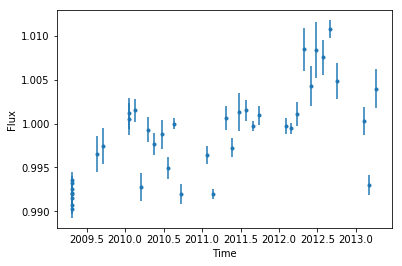

In [208]:
fig, ax = plt.subplots()
ax.errorbar(time.decimalyear, flux, yerr=err, fmt='.')
ax.set(xlabel='Time', ylabel='Flux')
plt.show()

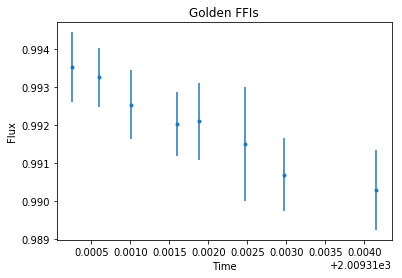

In [35]:
fig, ax = plt.subplots()
n_frames = 8
ax.errorbar(time.decimalyear[:n_frames], flux[:n_frames], 
            yerr=err[:n_frames], fmt='.')
ax.set(xlabel='Time', ylabel='Flux', title='Golden FFIs')
plt.show()

***

Total solar irradiance from SORCE at 1AU:

In [64]:
from astropy.utils.data import download_file 
from astropy.io import ascii

url = 'http://lasp.colorado.edu/data/sorce/tsi_data/daily/sorce_tsi_L3_c24h_latest.txt'
tsi_path = download_file(url, cache=True)

columns = ['nominal_date_yyyymmdd', 'nominal_date_jdn', 'avg_measurement_date_jdn', 'std_dev_measurement_date', 
           'tsi_1au', 'instrument_accuracy_1au', 'instrument_precision_1au', 'solar_standard_deviation_1au', 
           'measurement_uncertainty_1au', 'tsi_true_earth', 'instrument_accuracy_true_earth', 
           'instrument_precision_true_earth', 'solar_standard_deviation_true_earth', 
           'measurement_uncertainty_true_earth','provisional_flag']

table = ascii.read(tsi_path, names=columns, data_start=150)

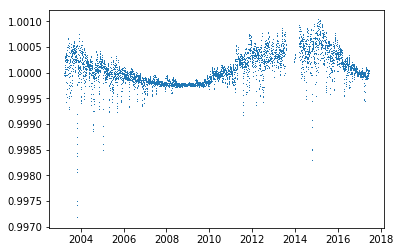

In [63]:
from astropy.constants import au, R_sun, L_sun

tsi_time = Time(table['avg_measurement_date_jdn'], format='jd')
tsi_1au = table['tsi_1au']
non_zero = tsi_1au != 0
tsi_time = tsi_time[non_zero]
tsi_1au = tsi_1au[non_zero]

solar_brightness = tsi_1au/np.median(tsi_1au)

plt.plot(tsi_time.decimalyear, solar_brightness,',')

***

Solar irradiance integrated over the kepler bandpass: 

In [129]:
kepler_wave, kepler_trans = np.loadtxt('data/kepler_response_hires1.txt', skiprows=8, unpack=True)

In [77]:
import pandas as pd

colnames = ['Date', 'skip0', 'min_wavelength', 'skip1', 'max_wavelength', 
            'inst_mode', 'version', 'irr', 'irr_err', 'skip2', 'quality']

sim = pd.read_csv('data/sorce_sim_L3_c24h_0240nm_2413nm_20030414_20170618.txt', 
                  skiprows=90, delimiter=' ', index_col=1, names=colnames)

In [98]:
pt = sim.pivot(columns='min_wavelength', values='irr')

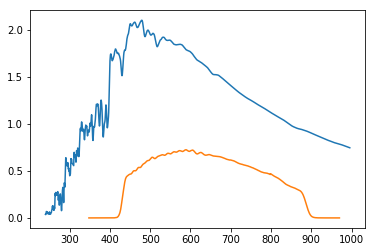

In [136]:
jd = 2454195.0
plt.plot(pt.loc[jd].index, pt.loc[jd].values)
plt.plot(kepler_wave, kepler_trans)

In [198]:
sim_irr = np.zeros(len(sim_jds))

for i, jd in enumerate(sim_jds):
    wavelengths = pt.loc[jd].index
    irradiances = pt.loc[jd].values
    interp_transmittance = np.interp(wavelengths, kepler_wave, kepler_trans)
    sim_irr[i] = np.nansum(interp_transmittance * irradiances)

sim_irr[(sim_irr < 244) | np.isnan(sim_irr)] = np.median(sim_irr)
sim_irr = sim_irr/np.median(sim_irr)

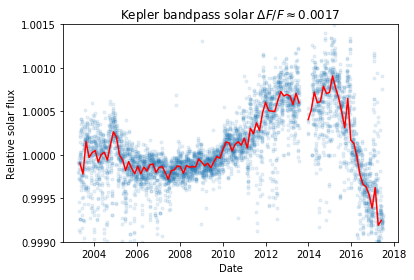

In [206]:
from scipy.stats import binned_statistic

bs = binned_statistic(sim_jds, sim_irr, statistic='median', bins=100)
bs_times = 0.5*(bs.bin_edges[:-1] + bs.bin_edges[1:])
deltaf_f = np.nanmax(bs.statistic) - np.nanmin(bs.statistic)

fig, ax = plt.subplots()
ax.plot_date(Time(sim_jds, format='jd').plot_date, sim_irr, '.', alpha=0.1)
ax.plot_date(Time(bs_times, format='jd').plot_date, bs.statistic, 'r')
ax.set(xlabel='Date', ylabel='Relative solar flux', 
       title=r'Kepler bandpass solar $\Delta F/F \approx {0:.4f}$'.format(deltaf_f))
ax.set_ylim([0.999, 1.0015])
plt.show()

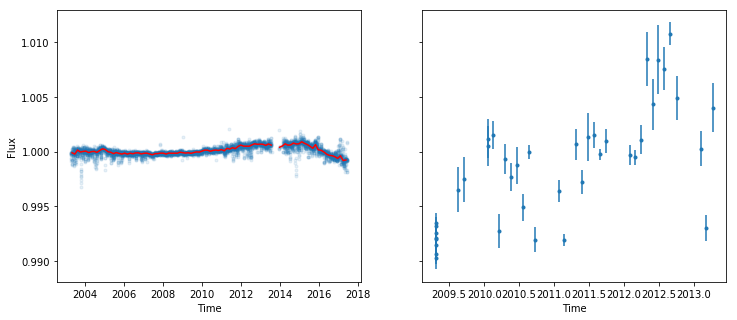

In [215]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
ax[0].plot_date(Time(sim_jds, format='jd').plot_date, sim_irr, '.', alpha=0.1)
ax[0].plot_date(Time(bs_times, format='jd').plot_date, bs.statistic, 'r')
ax[0].set(xlabel='Time', ylabel='Flux')

ax[1].errorbar(time.decimalyear, flux, yerr=err, fmt='.')
ax[1].set(xlabel='Time')
plt.show()

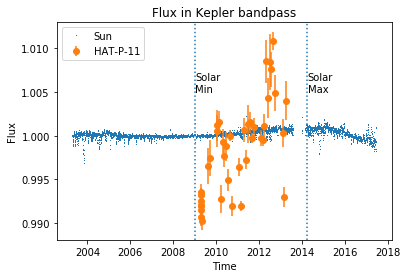

In [235]:
fig, ax = plt.subplots()
ax.plot(Time(sim_jds, format='jd').decimalyear, sim_irr, ',', label='Sun')
#ax.plot(Time(bs_times, format='jd').decimalyear, bs.statistic, 'r')
ax.errorbar(time.decimalyear, flux, yerr=err, fmt='o', label='HAT-P-11', zorder=10)
ax.legend(loc='upper left')
ax.set(xlabel='Time', ylabel='Flux', title='Flux in Kepler bandpass')

solar_max = Time('2014-04-01').decimalyear
solar_min = Time('2009-01-01').decimalyear
ax.axvline(solar_max, ls=':')
ax.text(solar_max+0.01, 1.005, 'Solar\nMax')
ax.axvline(solar_min, ls=':')
ax.text(solar_min+0.01, 1.005, 'Solar\nMin')
plt.show()